Import functions I generated under functionsused notebook

In [1]:
%run functionsused.ipynb

# Intraday Strategy

## Intraday strategy As described in the paper
The intraday momentum strategies include: 
- using the first half-hour rtn as timing signal 
- using the twelfth half-hour rtn as timing signal 
- using both the first and twelfth half-hour rtn as timing signal <br>
to bet the last half-hour return. <br>

The strategies are based on two main economic explanations:
- Could be driven by institutional investors' infrequent rebalancing. Some investors simply delay their rebalancing trading to near mkt close instead of mkt openinstitutional
- Presence of late-informed investors - information transmission can last up to a month across certain industries 

Is backtested through 
- returns 
- Sharpe 
- Skewness & Kurtosis 
- Success rate: pct of trading days with zero or positive returns 

Compared with (1) always long strategy (2) buy and hold strategy <br>

The paper also mentioned that their intraday momentum strategy perform consistently robust under different market conditions characterized by 
- financial crisis 
- volatility levels 
- trading volume
- institutional trading 
- business cycle or macro news releases 


## My analysis based on (1) data quality check and (2) strategy check 

My analysis below aims at verifying whether the market timing strategies work as described in the paper, across various ETFs, under the assumption of no transaction costs. <br>



### Intraday price data
The intraday price data provides daily indices price from 2012-01-03 to 2017-12-29. <br>
8 different timestamps (open,9:30,9:45,10:00,15:30,15:55,close). To be consistent with the paper, I used open (previous day close), 10:00, 15:30 and close pries. <br>
79 indices in total. Note: @FEDON looks abnormal. <br> 

For data cleaning, I prefer to make the process systematic. All analysis below is based on this principle.<br>

**No duplicates detected, but there are significant missing values issue.** <br>
- I decided to use price data from 2014-01-02 to 2017-12-29 since I observed that all the indices are missing 10:00 and 15:30 price until 2014-01-02.
- I further performed missing values treatment and eventually selected 51 indices that have missing data less than 10%. <br>
Note: instead of rejecting indices, we could also choose to perform data interpolation, i.e., impute missing values with median, mean, the nearby values, or based on research logic. But here, since the price data is crutial important for our strategy, imputing prices could have unpredictable impacts to our backtest results. I decided to drop missing records. <br>

**Price Outliers:** 
- I used SPY as a detailed example here to further check whether there are price outliers. 
- I didn't observe significant price jump/drop for SPY. If there are any, I would check the data online to verify whether the jump/drop are valid, and would drop the data record if the data is not valid. <br>
<br>
- For the other 50 selected ETFs, I attached the price quality check in notebook (IntradayStrategy_ETFDataQualityCheck). 
- Obsered abnormal price jump for 14 indices, from 2016-11-04 to 2016-11-07. Since there's only significant price jump on one day, there are two potential solutions to fix the data. 
1. Shift the jumped price after 2016-11-07. 
2. Considering the fact that all we need is the return (price change) and to make data consistent across ETFs, we could drop the return on 2016-11-07 for all indices. 


### Intraday momentum strategy results

Take SPY as an example, the correlation between first & last half-hour returns are poorly, which normally suggest there's no need for performing regression or other ML models. But I still repicated the strategy to further verify.<br>
- Since they are continuous data, I used scatter plot to viz relationship between the first&last half-hour returns and observed no trend.
- I confirmed no correlation conclusion as the pearson's correlation is only 0.01. <br>

To be consistent with the paper, I still performed insample and outsample regression. The results further valided my conclusion above. <br>
Note: since the data is from 2014 to 2017, for outsample analysis, I used rolling 1year data to perform recursive regression. (Paper used rolling 5y, progressively add one more month rtn each time.) 
- The R-squared is very poor, less than 0.1% for both Insample and Outsample average.
- Beta is extremely small, and not statistically significant - absolute t stats is way smaller than 2. 
- Skewness is negative while kurtosis is positive. <br>

Strategy performance: **bad**
- Average annualized return is slightly negative 
- Annualized Standard Deviation is 0.0009
- Annualized Sharpe ratio is -0.01
- Suceess rate is 46.48%

Similar results are observed for all other ETFs. The best performed ETF is EWZ which has a 0.07 annualized Sharpe, which makes sense as it has the highest corr between first&last half-hour returns. 

Various scenario analysis were performed to verify the effectiveness of strategy in the paper, among which they access impact of volatility on return predictability, by computing the return volatility for each minute return within the first half-hour. I tried to use 15minutes window to replicate this analysis, as we have 9:45 data, but given the fact that our first&last half-hour correlation is too poor, high vol days didn't improve the strategy. 

I tend to optimize this strategy, as listed below. 

### The strategy could be optimized, I would perform ...

**Data:** <br>
1. Calculating first half-hour rtn based on two price stamps sometimes are not robust (could be biased), I would smooth the open price using, for example the volume weighted price of nearby 5 minutes. 
    
**Model:** <br>
1. Although there are intuitive explannations for intraday mkt timing strategy. Given the fact that the correlation between the dependent&independent variables is poorly, I would recommend using other variables as predictors. The factors may have lost their power as time pass.
2. Single variable regression model tend to have low explaning power. I would recommend exploring multi-factors at least. 
3. For least square regression, I agree the (1) corr direction (2) significant level normally matters. But, to better test the effectiveness of the mkt timing strategy here. I would think a logistic regression could provide more information. As there are two outcomes of how to perform the strategy. Based on direction of correlation between first&last half-hour returns.
4. Transaction cost & Execution: I would analyze real mkt impacts on transaction cost and the sprd close to mkt close 
5. How to use scenario analysis: the paper performed scenario analysis for robustness check only, and didn't perform any optimizations to the strategies. (incld. financial crisis, volatility levels, trading volume, institutional trading and business cycle or macro news releases) <br>
    I would further use these information, i.e., only trade on days when there are bigger beta/R-sqaured. 
    

## Data Cleaning

### Read Data

In [2]:
timelist = ['open','930','945','1000','1530','1545','1555','close']
timeselected = ['1000','1530','close']
timeused=['open','1000','1530','close']

intraprice = pd.read_pickle('../data/intra.pk')
intraprice.columns = intraprice.columns.rename([None,'uid'])

display('The inputdata is viz below: ')
display(intraprice.head(1))
intraprice = intraprice[timelist]
display(intraprice.tail(1))
display('Number of days included: '+str(intraprice.shape[0]))


'The inputdata is viz below: '

1000                                                            \
uid        @FEDON AAXJ CNYA ECH EDEN EEMA EFNL EIDO EIRL EIS EMXC ENOR ENZL   
2012-01-03    nan  nan  nan nan  nan  nan  nan  nan  nan nan  nan  nan  nan   

                                                                               \
uid        EPHE EPOL EPP EPU ERUS EWA EWC EWD EWG EWH EWI EWJ EWK EWL EWM EWN   
2012-01-03  nan  nan nan nan  nan nan nan nan nan nan nan nan nan nan nan nan   

                                                                               \
uid        EWO EWP EWQ EWS EWT EWU EWW EWY EWZ EZA EZU GLD GXG IEFA IEMG IEUR   
2012-01-03 nan nan nan nan nan nan nan nan nan nan nan nan nan  nan  nan  nan   

                                                                             \
uid        INDA IVV IWM KSA MCHI QAT QQQ SPY SQQQ SSO SVXY THD TLT TQQQ TUR   
2012-01-03  nan nan nan nan  nan nan nan nan  nan nan  nan nan nan  nan nan   

                                                                               \
uid        UAE UPRO URTH VTI VTV VUG VXX VXZ XLB XLC XLE XLF XLI XLK XLP XLRE   
2012-01-03 nan  nan  nan nan nan nan nan nan nan nan nan nan nan nan nan  nan   

                         1530                                                  \
uid        XLU XLV XLY @FEDON AAXJ CNYA ECH EDEN EEMA EFNL EIDO EIRL EIS EMXC   
2012-01-03 nan nan nan    nan  nan  nan nan  nan  nan  nan  nan  nan nan  nan   

                                                                             \
uid        ENOR ENZL EPHE EPOL EPP EPU ERUS EWA EWC EWD EWG EWH EWI EWJ EWK   
2012-01-03  nan  nan  nan  nan nan nan  nan nan nan nan nan nan nan nan nan   

                                                                            \
uid        EWL EWM EWN EWO EWP EWQ EWS EWT EWU EWW EWY EWZ EZA EZU GLD GXG   
2012-01-03 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan   

                                                                               \
uid        IEFA IEMG IEUR INDA IVV IWM KSA MCHI QAT QQQ SPY SQQQ SSO SVXY THD   
2012-01-03  nan  nan  nan  nan nan nan nan  nan nan nan nan  nan nan  nan nan   

                                                                               \
uid        TLT TQQQ TUR UAE UPRO URTH VTI VTV VUG VXX VXZ XLB XLC XLE XLF XLI   
2012-01-03 nan  nan nan nan  nan  nan nan nan nan nan nan nan nan nan nan nan   

                                      1545                                    \
uid        XLK XLP XLRE XLU XLV XLY @FEDON AAXJ CNYA ECH EDEN EEMA EFNL EIDO   
2012-01-03 nan nan  nan nan nan nan    nan  nan  nan nan  nan  nan  nan  nan   

                                                                               \
uid        EIRL EIS EMXC ENOR ENZL EPHE EPOL EPP EPU ERUS EWA EWC EWD EWG EWH   
2012-01-03  nan nan  nan  nan  nan  nan  nan nan nan  nan nan nan nan nan nan   

                                                                            \
uid        EWI EWJ EWK EWL EWM EWN EWO EWP EWQ EWS EWT EWU EWW EWY EWZ EZA   
2012-01-03 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan   

                                                                              \
uid        EZU GLD GXG IEFA IEMG IEUR INDA IVV IWM KSA MCHI QAT QQQ SPY SQQQ   
2012-01-03 nan nan nan  nan  nan  nan  nan nan nan nan  nan nan nan nan  nan   

                                                                            \
uid        SSO SVXY THD TLT TQQQ TUR UAE UPRO URTH VTI VTV VUG VXX VXZ XLB   
2012-01-03 nan  nan nan nan  nan nan nan  nan  nan nan nan nan nan nan nan   

                                                      1555                     \
uid        XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY @FEDON AAXJ CNYA ECH EDEN   
2012-01-03 nan nan nan nan nan nan  nan nan nan nan    nan  nan  nan nan  nan   

                                                                              \
uid        EEMA EFNL EIDO EIRL EIS EMXC ENOR ENZL EPHE EPOL EPP EPU ERUS EWA   


open                                                              \
uid        @FEDON  AAXJ  CNYA   ECH  EDEN  EEMA  EFNL  EIDO  EIRL   EIS  EMXC   
2017-12-29    nan 76.53 32.15 52.43 67.40 74.19 39.42 28.48 48.19 51.58 53.94   

                                                                              \
uid         ENOR  ENZL  EPHE  EPOL   EPP   EPU  ERUS   EWA   EWC   EWD   EWG   
2017-12-29 25.78 47.88 38.91 27.18 47.97 40.87 33.61 23.28 29.78 34.02 33.14   

                                                                              \
uid          EWH   EWI   EWJ   EWK   EWL   EWM   EWN   EWO   EWP   EWQ   EWS   
2017-12-29 25.47 30.58 60.02 20.98 35.61 33.12 31.77 24.75 32.83 31.37 25.97   

                                                                               \
uid          EWT   EWU   EWW   EWY   EWZ   EZA   EZU    GLD   GXG  IEFA  IEMG   
2017-12-29 36.35 35.99 48.70 75.29 40.45 70.32 43.52 123.70 10.08 66.32 57.06   

                                                                            \
uid         IEUR  INDA    IVV    IWM   KSA  MCHI   QAT    QQQ    SPY  SQQQ   
2017-12-29 50.41 36.14 270.50 154.15 26.24 66.74 16.04 156.90 268.53 21.07   

                                                                              \
uid           SSO   SVXY   THD    TLT   TQQQ   TUR   UAE   UPRO  URTH    VTI   
2017-12-29 110.65 131.20 92.65 126.50 141.92 43.33 16.92 142.60 88.53 138.08   

                                                                          \
uid           VTV    VUG VXX VXZ   XLB XLC   XLE   XLF   XLI   XLK   XLP   
2017-12-29 106.93 141.56 nan nan 60.87 nan 72.66 28.20 75.97 64.33 56.90   

                                      930                                   \
uid         XLRE   XLU   XLV   XLY @FEDON  AAXJ CNYA   ECH EDEN  EEMA EFNL   
2017-12-29 32.96 52.81 83.33 99.30    nan 76.57  nan 52.39  nan 74.38  nan   

                                                                               \
uid         EIDO  EIRL EIS EMXC ENOR ENZL  EPHE  EPOL   EPP   EPU  ERUS   EWA   
2017-12-29 28.48 48.19 nan  nan  nan  nan 38.91 27.18 47.97 40.87 33.61 23.28   

                                                                            \
uid          EWC   EWD   EWG   EWH   EWI   EWJ   EWK   EWL   EWM EWN   EWO   
2017-12-29 29.78 34.02 33.14 25.47 30.58 60.02 20.98 35.61 33.12 nan 24.75   

                                                                            \
uid          EWP   EWQ   EWS   EWT   EWU   EWW   EWY   EWZ   EZA   EZU GLD   
2017-12-29 32.83 31.37 25.97 36.35 35.99 48.70 75.29 40.45 70.32 43.56 nan   

                                                                             \
uid          GXG  IEFA  IEMG  IEUR  INDA    IVV    IWM KSA  MCHI QAT    QQQ   
2017-12-29 10.08 66.31 57.06 50.41 36.14 270.50 154.15 nan 66.74 nan 156.90   

                                                                            \
uid           SPY SQQQ SSO SVXY   THD TLT TQQQ   TUR UAE UPRO  URTH    VTI   
2017-12-29 268.53  nan nan  nan 92.65 nan  nan 43.34 nan  nan 88.53 138.08   

                                                                          \
uid           VTV    VUG VXX VXZ   XLB XLC   XLE   XLF   XLI   XLK   XLP   
2017-12-29 106.93 141.56 nan nan 60.87 nan 72.66 28.20 75.97 64.33 56.90   

                                      945                                    \
uid         XLRE   XLU   XLV   XLY @FEDON  AAXJ CNYA   ECH  EDEN  EEMA EFNL   
2017-12-29 32.96 52.81 83.33 99.30    nan 76.59  nan 52.46 67.40 74.06  nan   

                                                                             \
uid         EIDO  EIRL EIS EMXC ENOR ENZL  EPHE  EPOL   EPP EPU  ERUS   EWA   
2017-12-29 28.55 47.79 nan  nan  nan  nan 38.91 27.13 47.90 nan 33.74 23.23   

                                                                              \
uid          EWC   EWD   EWG   EWH   EWI   EWJ   EWK   EWL   EWM   EWN   EWO   
2017-12-29 29.65 34.04 33.15 25.45 30.59 60.02 20.9

'Number of days included: 1509'

### Data Exploration

In [3]:
intraprice.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2012-01-03 to 2017-12-29
Columns: 632 entries, ('open', '@FEDON') to ('close', 'XLY')
dtypes: float64(632)
memory usage: 7.3 MB


**Check Duplicates**

In [4]:
##### check duplicates - no duplicates detected 
display('Number of days included: '+str(intraprice.shape[0]))
intraprice = intraprice.drop_duplicates()
display('Number of days included after drop duplicates: '+str(intraprice.shape[0]))


'Number of days included: 1509'

'Number of days included after drop duplicates: 1509'

In [5]:
##### One ETF that I didn't find on google, and it has bad data
intraprice.loc[:, (slice(None),'@FEDON')].describe()

,open,930,945,1000,1530,1545,1555,close
uid,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON
count,"1,187.00",0.00,0.00,0.00,0.00,0.00,0.00,"1,495.00"
mean,0.16,nan,nan,nan,nan,nan,nan,0.31
std,0.10,nan,nan,nan,nan,nan,nan,0.34
min,0.01,nan,nan,nan,nan,nan,nan,0.00
25%,0.09,nan,nan,nan,nan,nan,nan,0.09
50%,0.13,nan,nan,nan,nan,nan,nan,0.14
75%,0.17,nan,nan,nan,nan,nan,nan,0.40
max,0.42,nan,nan,nan,nan,nan,nan,1.41


**Specify all indices**

In [6]:
##### speficy available indices 
indiceslist = list(intraprice['open'].columns.values)[1:]
display('Number of indices that are included: '+str(len(indiceslist)))


'Number of indices that are included: 78'

**Missing Values Treatment**

CNYA don't have available price data that we need. To be excluded from our analysis.
EFNL don't have available price data that we need. To be excluded from our analysis.
EMXC don't have available price data that we need. To be excluded from our analysis.
ENOR don't have available price data that we need. To be excluded from our analysis.
GLD don't have available price data that we need. To be excluded from our analysis.
KSA don't have available price data that we need. To be excluded from our analysis.
QAT don't have available price data that we need. To be excluded from our analysis.
SQQQ don't have available price data that we need. To be excluded from our analysis.
SSO don't have available price data that we need. To be excluded from our analysis.
SVXY don't have available price data that we need. To be excluded from our analysis.
TLT don't have available price data that we need. To be excluded from our analysis.
TQQQ don't have available price data that we need. To be excluded from

'PctMissing is the original missing pct and PctMissingUpd is the missing pct starts 2014-01-02.'

,indices,PctMissing,FirstAvailableDate,PctMissingUpd
0,AAXJ,36.78,2014-01-02 00:00:00,5.26
1,ECH,36.32,2014-01-02 00:00:00,4.17


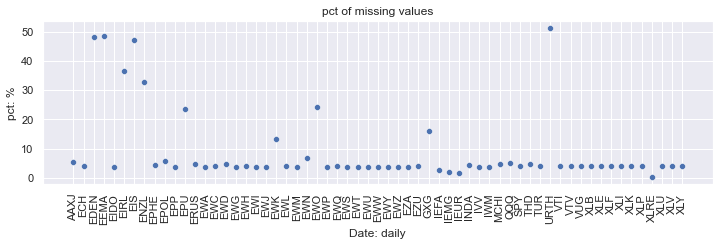

In [7]:
dataquality = data_coverage_check(df=intraprice, indiceslist=indiceslist)
    
dataquality = dataquality.reset_index().rename(columns={'index':'indices'})
display('PctMissing is the original missing pct and PctMissingUpd is the missing pct starts 2014-01-02.')
display(dataquality.head(2))
visualization(dataquality,x='indices',y='PctMissingUpd',title='pct of missing values',
              xlabel='Date: daily',ylabel='pct: %',rotation_angel=90, scatter=True)

**Selected 51 indices after performing missing value analysis**

'Number of indices that have historical data coverage over 90%: 51'

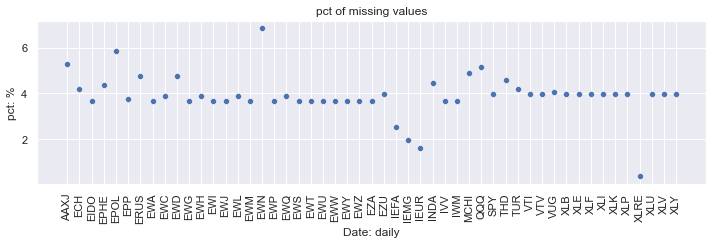

In [8]:
usableindices = dataquality.loc[dataquality.PctMissingUpd <10]
display('Number of indices that have historical data coverage over 90%: '+str(usableindices.shape[0]))

visualization(usableindices,x='indices',y='PctMissingUpd',title='pct of missing values',
              xlabel='Date: daily',ylabel='pct: %',rotation_angel=90, scatter=True)

**Selected input data with good coverage.**

In [9]:
intraprice = intraprice.loc[intraprice.index >= '2014-01-02',(slice(None),usableindices.indices)]
display(str(intraprice.shape[0])+' days are selected. With '+str(int(intraprice.shape[1]/intraprice.columns.get_level_values(0).nunique())) +' ETFs.')


'1007 days are selected. With 51 ETFs.'

### SPY Price Data Analysis 
No abnormal jump/drop observed in SPY price data.

In [10]:
SPY = price_outlier_analysis(df=intraprice, index='SPY')
display(SPY.head(2))

,date,open,1000,1530,close,r_open,r_close
0,2014-01-02,nan,183.55,182.99,182.92,nan,-0.00
1,2014-01-03,182.92,183.45,183.36,182.88,0.00,-0.00


**To verify whether there's abnormal price jump/drop. SPY price data looks normal.**

In [11]:
SPY.describe()

,open,1000,1530,close,r_open,r_close
count,"1,006.00",975.00,967.00,"1,007.00",974.00,967.00
mean,213.30,213.91,214.08,213.35,0.00,-0.00
std,20.98,20.96,21.00,21.04,0.01,0.00
min,174.17,174.53,174.95,174.17,-0.04,-0.02
25%,198.69,199.19,199.31,198.74,-0.00,-0.00
50%,208.72,208.88,209.04,208.73,0.00,0.00
75%,226.25,226.73,226.72,226.26,0.00,0.00
max,268.20,268.44,268.15,268.20,0.02,0.01


**Observed some missing values. Since the percentage is very small. I excluded these records.**

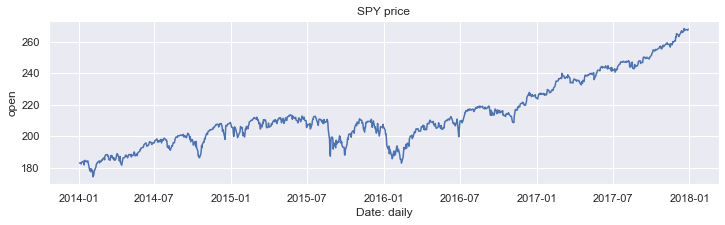

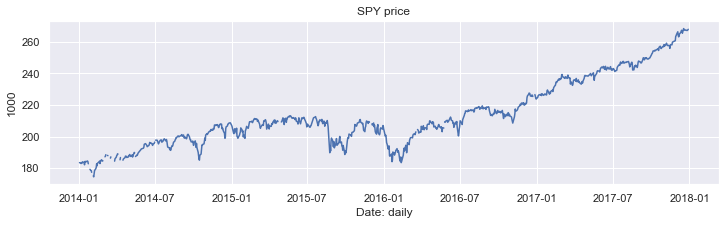

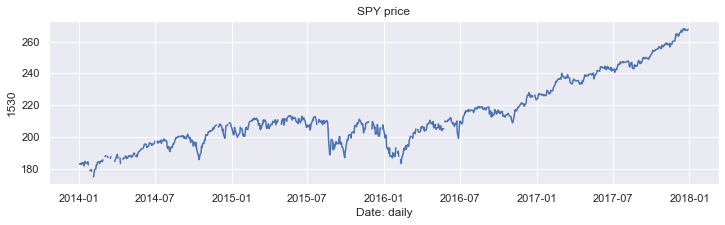

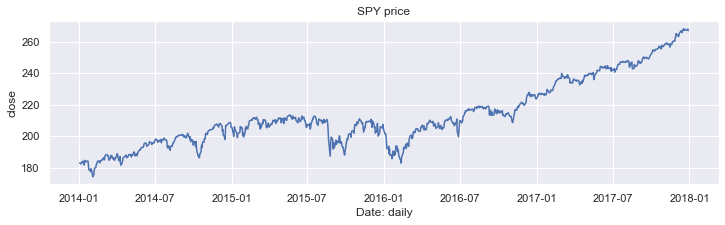

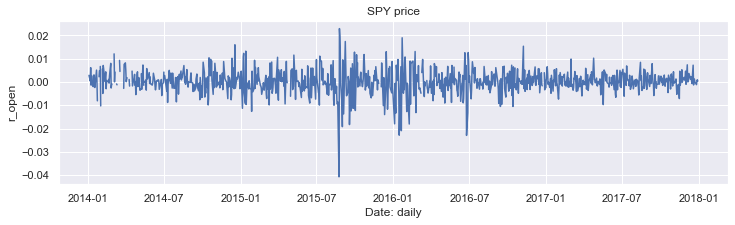

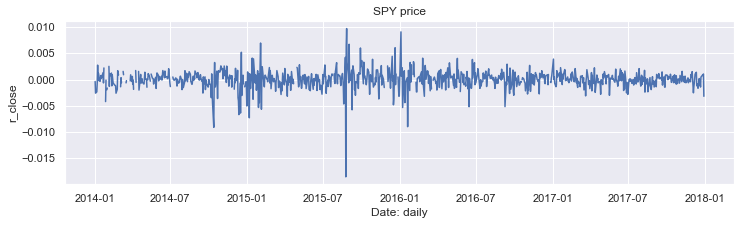

In [12]:
for time in SPY.columns[1:]:
    visualization(SPY,x="date",y=time,title='SPY price',xlabel='Date: daily',ylabel=time,rotation_angel=0)

**Drop Missing Values**

In [13]:
display(SPY.isnull().sum().to_frame().T)
display(SPY.shape)
SPY = SPY.dropna()
display(SPY.shape)
display(SPY.isnull().sum().to_frame().T)

,date,open,1000,1530,close,r_open,r_close
0,0,1,32,40,0,33,40


(1007, 7)

(966, 7)

,date,open,1000,1530,close,r_open,r_close
0,0,0,0,0,0,0,0


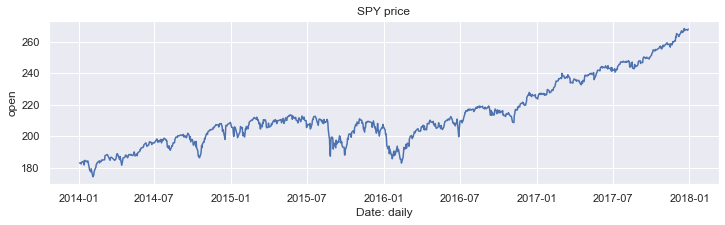

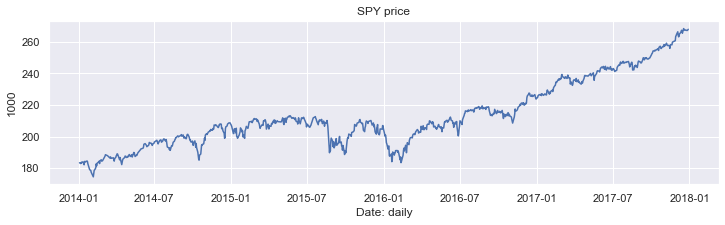

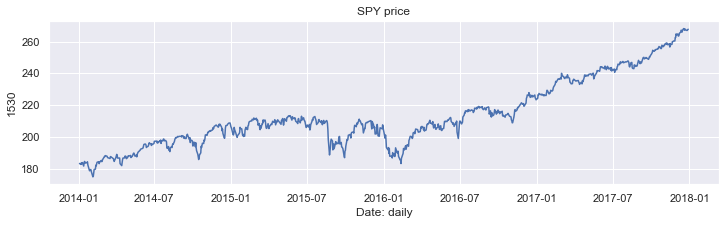

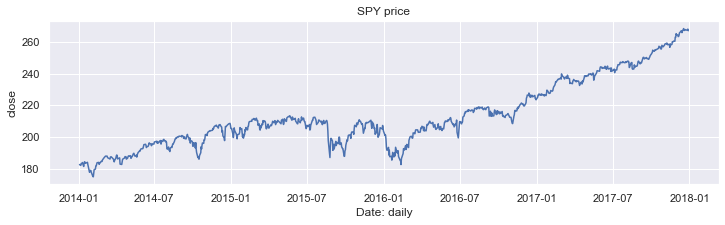

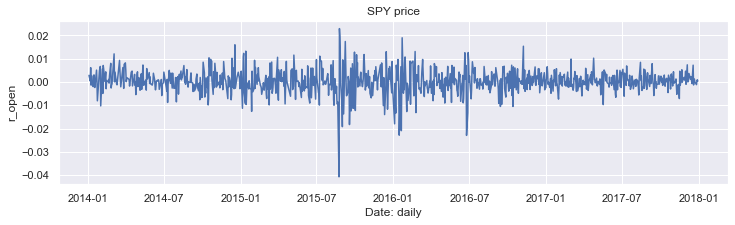

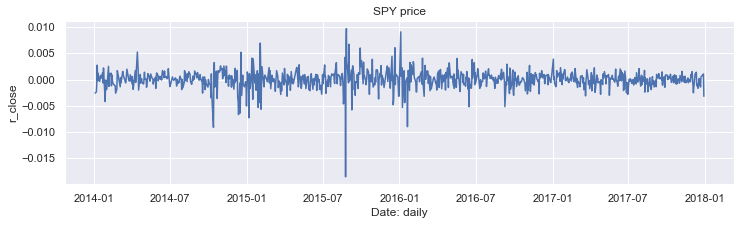

In [14]:
for time in SPY.columns[1:]:
    visualization(SPY,x="date",y=time,title='SPY price',xlabel='Date: daily',ylabel=time,rotation_angel=0)
    

## Strategy Analysis

### Intraday momentum strategy

**SPY returns**

In [15]:
SPY = get_rtn_data(SPY)
display(SPY.head(2))

,date,open,1000,1530,close,r_open,r_close
1,2014-01-03,182.92,183.45,183.36,182.88,0.00,-0.00
2,2014-01-06,182.88,182.97,182.79,182.36,0.00,-0.00


**Correlation Check**

No Trend observed in scatter plot, i.e., no clear increasing or decreasing trend. This means there is no correlation between the variables. Hence the predictor cannot be used for Regression or ML.

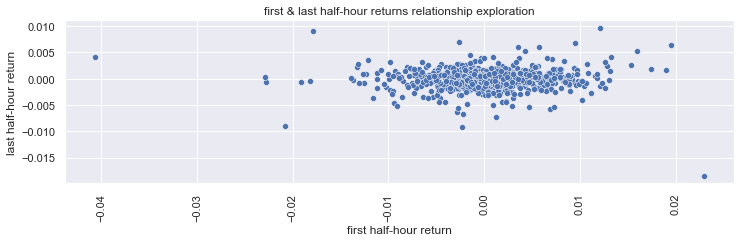

In [16]:
visualization(df=SPY,x='r_open',y='r_close',title='first & last half-hour returns relationship exploration',
              xlabel='first half-hour return',ylabel='last half-hour return',rotation_angel=90, scatter=True)

Pearson's correlation value is 0.01, further proved the above no correlation conclusion. 

In [17]:
correlationData = SPY[['r_open','r_close']].corr()
correlationData

,r_open,r_close
r_open,1.00,0.01
r_close,0.01,1.00


**In-sample Analysis**

In [18]:
insample_stats, insample_model = get_regression_stats(SPY,'r_close','r_open')
insample_stats

{'alpha_mean': 1.0774679975011223e-20,
 'alpha_vol': 0.0017631708411622123,
 'beta_coef': 0.002584221410334993,
 'beta_pvalue': 0.8167523577597646,
 'beta_tstats': 0.23178737200109426,
 'r_square': 5.572862217562147e-05}

In [19]:
insample_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                r_close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05373
Date:                Sun, 30 Apr 2023   Prob (F-statistic):              0.817
Time:                        18:36:20   Log-Likelihood:                 4754.9
No. Observations:                 966   AIC:                            -9506.
Df Residuals:                     964   BIC:                            -9496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.826e-05   5.68e-05     -0.321      0.748      -0.000    9.33e-05
r_open         0.0026      0.011      0.232      0.817      -0.019       0.024
==============================================================================
Omnibus:                      399.041   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11234.592
Skew:                          -1.280   Prob(JB):                         0.00
Kurtosis:                      19.510   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Out-sample Analysis**

In [20]:
rolling_stats = get_rolling_regression_stats(SPY,'r_close','r_open',252)

In [21]:
rolling_stats.head(2)

,date,r_square,beta_coef,beta_tstats,beta_pvalue,alpha_mean,alpha_vol
0,2014-01-03,0.00,0.00,0.00,0.00,0.00,0.00
1,2014-01-06,0.00,0.00,0.00,0.00,0.00,0.00


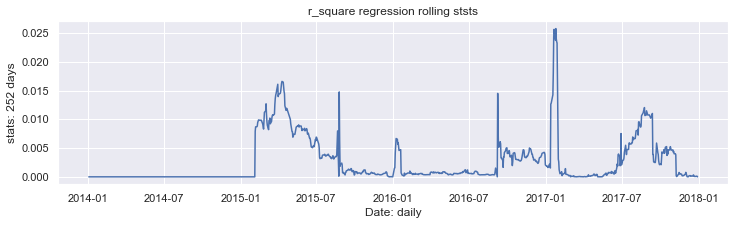

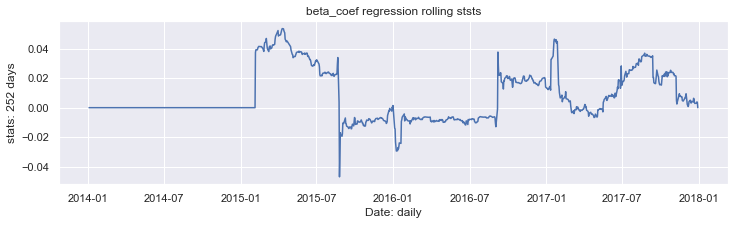

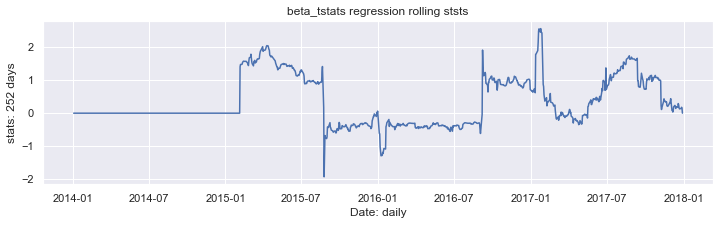

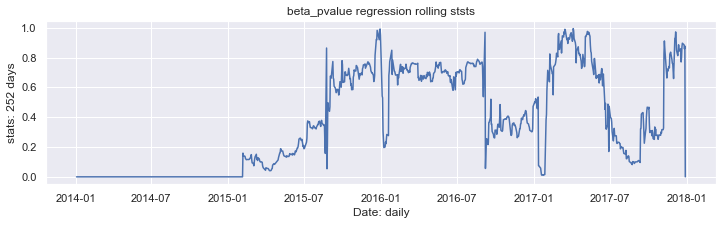

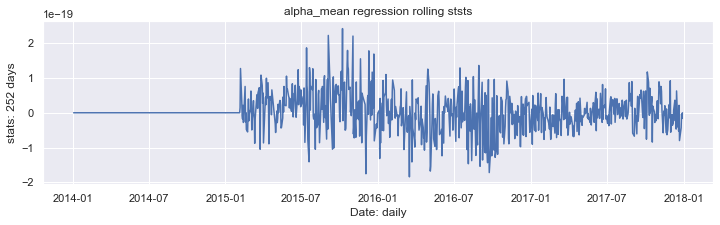

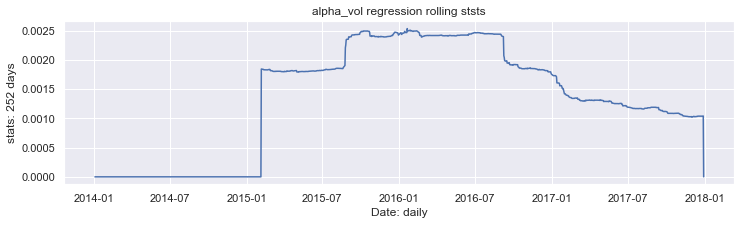

In [22]:
for var in rolling_stats.columns[1:]:
    visualization(rolling_stats,x='date',y=var,title=var + ' regression rolling ststs',
              xlabel='Date: daily',ylabel='stats: 252 days',rotation_angel=0)

**Strategy Returns**

In [23]:
##### calculate returns
SPY = get_strat_rtn(SPY)
SPY.head(2)

,date,open,1000,1530,close,r_open,r_close,rtn
1,2014-01-03,182.92,183.45,183.36,182.88,0.00,-0.00,-0.00
2,2014-01-06,182.88,182.97,182.79,182.36,0.00,-0.00,-0.00


In [24]:
##### calculate backtesting metrics
# Successrate is in %
backtest_metric = backtesting_metrics(SPY,'rtn','SPY')
backtest_metric

,rtn,std,Sharpe,Successrate
SPY,-0.00,0.00,-0.01,46.48


In [25]:
100*backtest_metric[['rtn', 'std', 'Sharpe']]

,rtn,std,Sharpe
SPY,-0.00,0.09,-1.25


### Other ETFs

In [26]:
ETF_backtest_rst = pd.DataFrame()

for index in intraprice.columns.get_level_values(1).unique():
    tmp = ETF_backtest(df=intraprice, index=index)
    ETF_backtest_rst = pd.concat([ETF_backtest_rst,tmp])
    
    

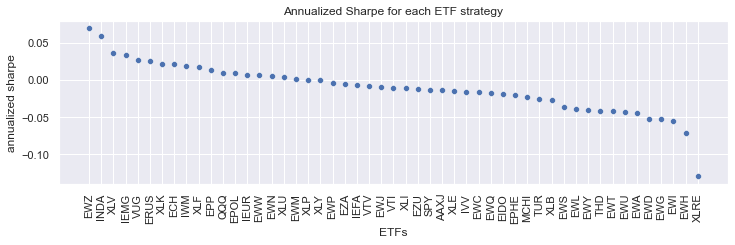

In [27]:
visualization(ETF_backtest_rst.reset_index().sort_values(by='Sharpe',ascending=False),x='index',y='Sharpe',title='Annualized Sharpe for each ETF strategy',
              xlabel='ETFs',ylabel='annualized sharpe',rotation_angel=90, scatter=True)

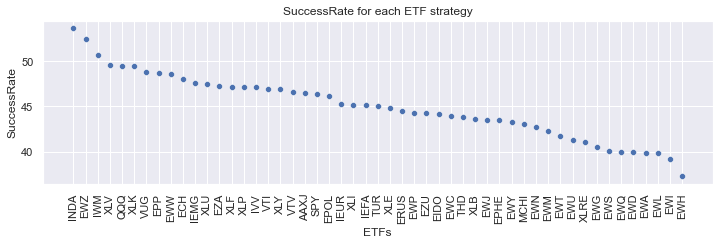

In [28]:
visualization(ETF_backtest_rst.reset_index().sort_values(by='SuccessRate',ascending=False),x='index',y='SuccessRate',title='SuccessRate for each ETF strategy',
              xlabel='ETFs',ylabel='SuccessRate',rotation_angel=90, scatter=True)

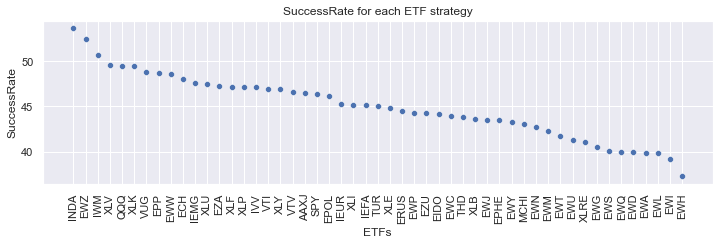

In [29]:
visualization(ETF_backtest_rst.reset_index().sort_values(by='SuccessRate',ascending=False),x='index',y='SuccessRate',title='SuccessRate for each ETF strategy',
              xlabel='ETFs',ylabel='SuccessRate',rotation_angel=90, scatter=True)

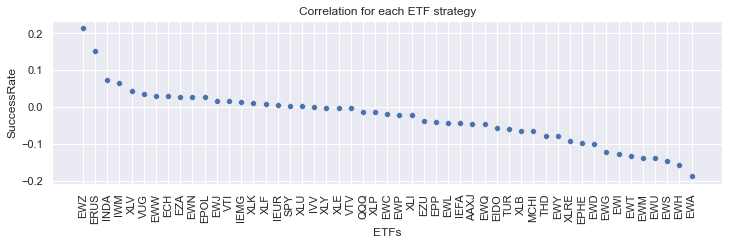

In [30]:
visualization(ETF_backtest_rst.reset_index().sort_values(by='corr',ascending=False),x='index',y='corr',title='Correlation for each ETF strategy',
              xlabel='ETFs',ylabel='SuccessRate',rotation_angel=90, scatter=True)

In [31]:
ETF_backtest_rst.sort_values(by='Sharpe',ascending=False).head()

,corr,reg_beta,reg_beta_tstats,r_squared,rtn,rtn_std,Sharpe,SuccessRate
EWZ,0.21,0.04,6.78,0.05,0.00,0.00,0.07,52.48
INDA,0.07,0.01,2.27,0.01,0.00,0.00,0.06,53.66
XLV,0.04,0.01,1.31,0.00,0.00,0.00,0.04,49.53
IEMG,0.01,0.00,0.33,0.00,0.00,0.00,0.03,47.63
VUG,0.04,0.01,1.09,0.00,0.00,0.00,0.03,48.86
